This code will load the model information, generate the model definition, and run the model estimation using FSL

In [102]:
import nipype.algorithms.modelgen as model   # model generation
from  nipype.interfaces import fsl, ants      
from nipype.interfaces.base import Bunch
import os,json,glob,sys
import numpy
import nibabel
import nilearn.plotting

%matplotlib inline
import matplotlib.pyplot as plt

datadir='/home/jovyan/ClassData/'
    
results_dir = '/home/jovyan/ClassData/LabResults'#os.path.abspath("../../results")
if not os.path.exists(results_dir):
    os.mkdir(results_dir)

from nipype.caching import Memory
mem = Memory(base_dir='.')

print('Using data from',datadir)

Using data from /home/jovyan/ClassData/


In [103]:
from bids import BIDSLayout
layout = BIDSLayout(datadir,validate=False)
layout

BIDS Layout: .../home/jovyan/ClassData | Subjects: 10 | Sessions: 0 | Runs: 30

In [104]:
#Psych60 Now lets look at what our data layout is a little closer.
#BIDS format is described in more depth here http://bids.neuroimaging.io/
#Please go and read up a little on BIDS and why it is important

In [105]:
layout.get_subjects()

['sid000006',
 'sid000118',
 'sid000689',
 'sid000747',
 'sid001548',
 'sid001550',
 'sid001551',
 'sid001560',
 'sid001561',
 'sid001562']

In [106]:
layout.get_tasks()

['mental']

In [107]:
source_epi=layout.get(task="mental", extensions="nii")[0]
layout.get(task="mental", extensions="nii")[0].path

'/home/jovyan/ClassData/sub-sid000006/func/sub-sid000006_task-mental_run-01_bold_space-MNI152NLin2009cAsym_preproc.nii'

In [108]:
#What does this tell us about this particular file?
source_epi.entities

{'datatype': 'func', 'extension': 'nii', 'run': 1, 'space': 'MNI152NLin2009cAsym', 'subject': 'sid000006', 'suffix': 'preproc', 'task': 'mental'}

In [109]:
import pandas as pd
events1 = pd.read_csv(os.path.join(datadir, "onsets1.csv"), sep=",")
events2 = pd.read_csv(os.path.join(datadir, "onsets2.csv"), sep=",")
events3 = pd.read_csv(os.path.join(datadir, "onsets3.csv"), sep=",")

In [110]:
#For now we are going to model each run independently, then get subject and group level maps later

#offset=600 #10 minute runs
#offset
#events2

In [111]:
#make offsets for our runs
#events2.onset=events2.onset+offset
#events3.onset=events3.onset+offset*2

In [112]:
frames=[events1,events2,events3]
events=pd.concat(frames)

In [113]:
events

,Event Number,trial_type,onset,duration
0,1,Social,0.0,8.0
1,2,Career,8.0,8.0
2,3,Career,16.0,8.0
3,4,Event,24.0,8.0
4,5,Career,32.0,8.0
...,...,...,...,...
70,71,School,560.0,8.0
71,72,Event,568.0,8.0
72,73,Event,576.0,8.0
73,74,Social,584.0,8.0


In [114]:
#Do you have the correct number of events?

In [115]:
for trial_type in events.trial_type.unique():
    print(events[events.trial_type == trial_type])

    Event Number trial_type  onset  duration
0              1     Social    0.0       8.0
5              6     Social   40.0       8.0
20            21     Social  160.0       8.0
22            23     Social  176.0       8.0
24            25     Social  192.0       8.0
..           ...        ...    ...       ...
63            64     Social  504.0       8.0
64            65     Social  512.0       8.0
66            67     Social  528.0       8.0
73            74     Social  584.0       8.0
74            75     Social  592.0       8.0

[73 rows x 4 columns]
    Event Number trial_type  onset  duration
1              2     Career    8.0       8.0
2              3     Career   16.0       8.0
4              5     Career   32.0       8.0
16            17     Career  128.0       8.0
17            18     Career  136.0       8.0
34            35     Career  272.0       8.0
54            55     Career  432.0       8.0
55            56     Career  440.0       8.0
63            64     Career  504

In [116]:
#Psych60
#Please save notebook before proceeding!

## Run for 1 subject


In [117]:
confoundfiles=layout.get(task="mental", extensions="tsv",subject='sid000006')
confoundfiles[0]

<BIDSDataFile filename='/home/jovyan/ClassData/sub-sid000006/func/sub-sid000006_task-mental_run-01_bold_confounds.tsv'>

In [118]:
confounds1=pd.read_csv(confoundfiles[0].path,sep="\t", na_values="n/a")
confounds1

,CSF,WhiteMatter,GlobalSignal,stdDVARS,non-stdDVARS,vx-wisestdDVARS,FramewiseDisplacement,tCompCor00,tCompCor01,tCompCor02,...,Cosine06,Cosine07,NonSteadyStateOutlier00,NonSteadyStateOutlier01,X,Y,Z,RotX,RotY,RotZ
0,431.105579,331.009736,317.126828,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.0,0.0,-1.094640e-06,0.010417,0.033186,-0.000401,-0.000000,0.000098
1,426.032293,331.078836,316.138955,1.111633,25.298738,1.050569,0.119508,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,1.0,5.694270e-07,-0.010919,-0.025084,0.000229,0.000071,0.000000
2,422.695889,331.132979,315.428557,1.056540,24.044916,0.949374,0.073648,-0.062248,0.026564,0.036978,...,0.057822,0.057819,0.0,0.0,-7.209770e-03,-0.028054,0.002503,0.000502,-0.000000,-0.000091
3,421.609950,331.326452,315.364601,1.112622,25.321247,0.983221,0.136133,-0.038306,0.044321,0.004155,...,0.057744,0.057717,0.0,0.0,-8.026510e-03,0.038231,0.036120,-0.000022,0.000115,-0.000160
4,421.631193,331.423263,315.701512,1.169296,26.611036,0.990174,0.076931,-0.015049,0.042935,-0.017770,...,0.057587,0.057513,0.0,0.0,-3.871830e-03,0.029381,0.000602,-0.000508,0.000164,-0.000194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,420.354143,329.311350,313.823152,1.109947,25.260361,0.961815,0.207608,0.003919,-0.067486,-0.038608,...,-0.057041,0.056800,0.0,0.0,-2.306610e-01,0.304155,-0.301003,0.012153,0.003720,-0.007456
596,419.094146,328.937394,313.428551,1.151507,26.206194,0.902657,0.058097,-0.024815,-0.036098,-0.015641,...,-0.057353,0.057207,0.0,0.0,-2.298880e-01,0.301005,-0.272932,0.012534,0.003815,-0.007410
597,419.078540,329.205315,313.582443,1.048994,23.873188,0.915274,0.214650,-0.047629,-0.014450,0.008121,...,-0.057587,0.057513,0.0,0.0,-2.288180e-01,0.358600,-0.205660,0.011393,0.003370,-0.007598
598,420.647751,329.152475,313.613842,0.986995,22.462191,0.900272,0.155345,-0.050291,-0.001075,0.035522,...,-0.057744,0.057717,0.0,0.0,-2.270190e-01,0.319049,-0.273635,0.012171,0.003324,-0.007501


In [119]:
confounds1=pd.read_csv(confoundfiles[0].path,sep="\t", na_values="n/a")
confounds2=pd.read_csv(confoundfiles[1].path,sep="\t", na_values="n/a")
confounds3=pd.read_csv(confoundfiles[2].path,sep="\t", na_values="n/a")
frames=[confounds1,confounds2,confounds3]
confounds=pd.concat(frames)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


In [120]:
#Psych60 - please answer inline
#What regressors are we using? 
#What types of trials are we looking at?
#What type of noise do they account for? Google is your friend for this part...

info = [Bunch(conditions=['Social',
                          'Event',
                          'School',
                          'Career'],
              onsets=[list(events[events1.trial_type == 'Social'].onset),
                      list(events[events1.trial_type == 'Event'].onset),
                      list(events[events1.trial_type == 'School'].onset),
                      list(events[events1.trial_type == 'Career'].onset)],
              durations=[list(events[events1.trial_type == 'Social'].duration),
                          list(events[events1.trial_type == 'Event'].duration),
                          list(events[events1.trial_type == 'School'].duration),
                          list(events[events1.trial_type == 'Career'].duration)],
             regressors=[list(confounds1.FramewiseDisplacement.fillna(0)),
                         list(confounds1.aCompCor00),
                         list(confounds1.aCompCor01),
                         list(confounds1.aCompCor02),
                         list(confounds1.aCompCor03),
                         list(confounds1.aCompCor04),
                         list(confounds1.aCompCor05),
                        ],
             regressor_names=['FramewiseDisplacement',
                              'aCompCor00',
                              'aCompCor01',
                              'aCompCor02',
                              'aCompCor03',
                              'aCompCor04',
                              'aCompCor05',])
       ]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame inde

In [121]:
#get all preprocessed files for subject 6
source_epi=layout.get(task="mental", extensions="nii", subject='sid000006')
source_epi

[<BIDSImageFile filename='/home/jovyan/ClassData/sub-sid000006/func/sub-sid000006_task-mental_run-01_bold_space-MNI152NLin2009cAsym_preproc.nii'>,
 <BIDSImageFile filename='/home/jovyan/ClassData/sub-sid000006/func/sub-sid000006_task-mental_run-02_bold_space-MNI152NLin2009cAsym_preproc.nii'>,
 <BIDSImageFile filename='/home/jovyan/ClassData/sub-sid000006/func/sub-sid000006_task-mental_run-03_bold_space-MNI152NLin2009cAsym_preproc.nii'>]

In [122]:
%whos

Variable                Type               Data/Info
----------------------------------------------------
BIDSLayout              type               <class 'bids.layout.layout.BIDSLayout'>
Bunch                   type               <class 'nipype.interfaces.base.support.Bunch'>
Memory                  type               <class 'nipype.caching.memory.Memory'>
ants                    module             <module 'nipype.interface<...>rfaces/ants/__init__.py'>
career_cond             list               n=4
cc                      ndarray            15x15: 225 elems, type `float64`, 1800 bytes
confoundfiles           list               n=3
confounds               DataFrame                      CSF  Cosine00<...>n[1800 rows x 36 columns]
confounds1              DataFrame                      CSF  WhiteMat<...>\n[600 rows x 35 columns]
confounds2              DataFrame                      CSF  WhiteMat<...>\n[600 rows x 36 columns]
confounds3              DataFrame                      CSF  W

In [123]:
#This part defines what is brain and what is not and if we wanted we could trim timepoints we didn't want by changing t_min 
#skip = mem.cache(fsl.ExtractROI)
#skip_results1 = skip(in_file=source_epi[0].path,t_min=0, t_size=-1)
#skip_results2 = skip(in_file=source_epi[1].path,t_min=0, t_size=-1)
#skip_results3 = skip(in_file=source_epi[2].path,t_min=0, t_size=-1)

In [124]:
#Please read down to the bottom of this and answer questions before running:
#What other ways are we removing noise?
#Any other special parameters that we are using in the model?

filelist=[source_epi[0].path, source_epi[1].path, source_epi[2].path]
s = model.SpecifyModel()
s.inputs.input_units = 'secs'
s.inputs.functional_runs = source_epi[0].path#filelist#skip_results.outputs.roi_file
s.inputs.time_repetition = 1 #1 second TR #layout.get_metadata(source_epi.filename)["RepetitionTime"]
s.inputs.high_pass_filter_cutoff = 128.
s.inputs.subject_info = info
specify_model_results = s.run()
s.inputs


bids_amplitude_column = <undefined>
bids_condition_column = trial_type
bids_event_file = <undefined>
event_files = <undefined>
functional_runs = ['/home/jovyan/ClassData/sub-sid000006/func/sub-sid000006_task-mental_run-01_bold_space-MNI152NLin2009cAsym_preproc.nii']
high_pass_filter_cutoff = 128.0
input_units = secs
outlier_files = <undefined>
parameter_source = SPM
realignment_parameters = <undefined>
subject_info = [Bunch(conditions=['Social', 'Event', 'School', 'Career'], durations=[[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, nan, 8.0, 8.0, 8.0, nan, 8.0, 8.0, 8.0, nan, 8.0, 8.0, 8.0, 8.0, nan, nan, 8.0, 8.0, 8.0, 8.0, nan, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, nan, nan, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0], [8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, nan, 8.0, 8.0, 8.0, nan, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 

In [125]:
#This sets up contrasts for each condition individually and then compares Lips vs others
#Contrasts are the relative weight of the parameter estimates (betas) for each condition

social_cond = ['Social','T', ['Social'],[1]]
event_cond = ['Event','T', ['Event'],[1]]
school_cond = ['School','T', ['School'],[1]]
career_cond = ['School','T', ['School'],[1]]
school_vs_others = ["School vs. others",'T', ['School', 'Event', 'Social','Career'],[1, -1/3, -1/3, -1/3]]

In [126]:
#Psych 60
#please write your own code for career_vs_others here
#by copying and pasting the code above to below this line and modifying it


In [127]:
#Setting up one more contrast, an F contrast, think ANOVA

#all_task = ["All", 'F', [social_cond, event_cond, school_cond]]
contrasts=[social_cond, event_cond, school_cond, career_cond, school_vs_others]#, all_task]
#[social_cond, event_cond, school_cond, career_cond, school_vs_others, career_vs_others, all_task]
           
level1design = mem.cache(fsl.model.Level1Design)
level1design_results = level1design(interscan_interval = 1,#layout.get_metadata(source_epi.filename)["RepetitionTime"],
                                    bases = {'dgamma':{'derivs': True}},
                                    session_info = specify_model_results.outputs.session_info,
                                    model_serial_correlations=True,
                                    contrasts=contrasts)

level1design_results.outputs

191109-12:38:54,466 nipype.workflow INFO:
	 [Node] Setting-up "f4f3f983181d81d3a55cfcef69408e77" in "/home/jovyan/nipype_mem/nipype-interfaces-fsl-model-Level1Design/f4f3f983181d81d3a55cfcef69408e77".
191109-12:38:54,561 nipype.workflow INFO:
	 [Node] Running "f4f3f983181d81d3a55cfcef69408e77" ("nipype.interfaces.fsl.model.Level1Design")
191109-12:38:54,597 nipype.workflow INFO:
	 [Node] Finished "f4f3f983181d81d3a55cfcef69408e77".



ev_files = ['/home/jovyan/nipype_mem/nipype-interfaces-fsl-model-Level1Design/f4f3f983181d81d3a55cfcef69408e77/ev_Social_0_1.txt', '/home/jovyan/nipype_mem/nipype-interfaces-fsl-model-Level1Design/f4f3f983181d81d3a55cfcef69408e77/ev_Event_0_3.txt', '/home/jovyan/nipype_mem/nipype-interfaces-fsl-model-Level1Design/f4f3f983181d81d3a55cfcef69408e77/ev_School_0_5.txt', '/home/jovyan/nipype_mem/nipype-interfaces-fsl-model-Level1Design/f4f3f983181d81d3a55cfcef69408e77/ev_Career_0_7.txt', '/home/jovyan/nipype_mem/nipype-interfaces-fsl-model-Level1Design/f4f3f983181d81d3a55cfcef69408e77/ev_FramewiseDisplacement_0_9.txt', '/home/jovyan/nipype_mem/nipype-interfaces-fsl-model-Level1Design/f4f3f983181d81d3a55cfcef69408e77/ev_aCompCor00_0_10.txt', '/home/jovyan/nipype_mem/nipype-interfaces-fsl-model-Level1Design/f4f3f983181d81d3a55cfcef69408e77/ev_aCompCor01_0_11.txt', '/home/jovyan/nipype_mem/nipype-interfaces-fsl-model-Level1Design/f4f3f983181d81d3a55cfcef69408e77/ev_aCompCor02_0_12.txt', '/home

In [128]:
modelgen = mem.cache(fsl.model.FEATModel)
modelgen_results = modelgen(fsf_file=level1design_results.outputs.fsf_files,
                            ev_files=level1design_results.outputs.ev_files)
modelgen_results.outputs

191109-12:38:54,611 nipype.workflow INFO:
	 [Node] Setting-up "c06d380b4df8cd395850ee1811f3a3ba" in "/home/jovyan/nipype_mem/nipype-interfaces-fsl-model-FEATModel/c06d380b4df8cd395850ee1811f3a3ba".
191109-12:38:54,616 nipype.workflow INFO:
	 [Node] Running "c06d380b4df8cd395850ee1811f3a3ba" ("nipype.interfaces.fsl.model.FEATModel"), a CommandLine Interface with command:
feat_model run0 
191109-12:38:55,943 nipype.workflow INFO:
	 [Node] Finished "c06d380b4df8cd395850ee1811f3a3ba".



con_file = /home/jovyan/nipype_mem/nipype-interfaces-fsl-model-FEATModel/c06d380b4df8cd395850ee1811f3a3ba/run0.con
design_cov = /home/jovyan/nipype_mem/nipype-interfaces-fsl-model-FEATModel/c06d380b4df8cd395850ee1811f3a3ba/run0_cov.png
design_file = /home/jovyan/nipype_mem/nipype-interfaces-fsl-model-FEATModel/c06d380b4df8cd395850ee1811f3a3ba/run0.mat
design_image = /home/jovyan/nipype_mem/nipype-interfaces-fsl-model-FEATModel/c06d380b4df8cd395850ee1811f3a3ba/run0.png
fcon_file = <undefined>

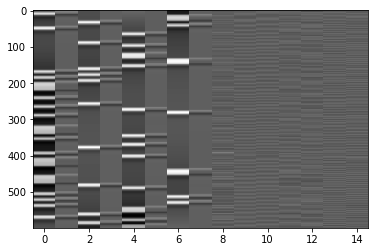

In [129]:
# This shows our study design
# What do each of the columns represent?
desmtx=numpy.loadtxt(modelgen_results.outputs.design_file,skiprows=5)
plt.imshow(desmtx,aspect='auto',interpolation='nearest',cmap='gray')

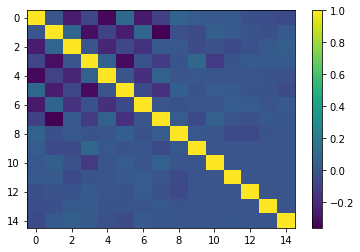

In [130]:
#Correlation matrix of our regressors 
#are any of them highly correlated? Would this be a problem?

cc=numpy.corrcoef(desmtx.T)
plt.imshow(cc,aspect='auto',interpolation='nearest', cmap=plt.cm.viridis)
plt.colorbar()

In [131]:
#mask = mem.cache(fsl.maths.ApplyMask)
#mask_results = mask(in_file=skip_results.outputs.roi_file,
#                    mask_file=os.path.join(datadir, "derivatives", "fmriprep", 
#                                        "sub-%s"%source_epi.subject, "ses-%s"%source_epi.session, "func", 
#                                        "sub-%s_ses-%s_task-fingerfootlips_bold_space-mni152nlin2009casym_brainmask.nii.gz"%(source_epi.subject,
#                                                                                                                             source_epi.session)))
#mask_results.outputs

In [132]:
skip = mem.cache(fsl.ExtractROI)
skip_results1 = skip(in_file=source_epi[0].path,t_min=500, t_size=-1)

191109-12:38:56,396 nipype.workflow INFO:
	 [Node] Setting-up "35ab2a3914957fd3d652576af313884d" in "/home/jovyan/nipype_mem/nipype-interfaces-fsl-utils-ExtractROI/35ab2a3914957fd3d652576af313884d".
191109-12:38:56,398 nipype.workflow INFO:
	 [Node] Cached "35ab2a3914957fd3d652576af313884d" - collecting precomputed outputs
191109-12:38:56,399 nipype.workflow INFO:
	 [Node] "35ab2a3914957fd3d652576af313884d" found cached.


In [133]:
#mask=layout.get(space='MNI152NLin2009cAsym',suffix='brainmask',extension="nii.gz")

In [134]:
mask = mem.cache(fsl.maths.ApplyMask)
mask_results = mask(in_file=source_epi[0].path,mask_file='/home/jovyan/ClassData/sub-sid000006/func/sub-sid000006_task-mental_run-01_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz')

191109-12:38:56,414 nipype.workflow INFO:
	 [Node] Setting-up "5029729351e114e8a65edcb6c71930ec" in "/home/jovyan/nipype_mem/nipype-interfaces-fsl-maths-ApplyMask/5029729351e114e8a65edcb6c71930ec".
191109-12:38:56,416 nipype.workflow INFO:
	 [Node] Cached "5029729351e114e8a65edcb6c71930ec" - collecting precomputed outputs
191109-12:38:56,417 nipype.workflow INFO:
	 [Node] "5029729351e114e8a65edcb6c71930ec" found cached.


In [135]:
mask_results.outputs.out_file #show us the filename of our masked EPI

'/home/jovyan/nipype_mem/nipype-interfaces-fsl-maths-ApplyMask/5029729351e114e8a65edcb6c71930ec/sub-sid000006_task-mental_run-01_bold_space-MNI152NLin2009cAsym_preproc_masked.nii.gz'

In [ ]:
#This section takes a LONG time. This may be as far as we make it during class today.
#While this is running - how many timepoints does it say we have? How many timeseries?
#Once this is done, how long did it take in total? How long do we need to allow to run all 3 runs for all participants?

#Actually fit the GLM to our data: see https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FEAT/UserGuide#FILM_General_Linear_Model

filmgls = mem.cache(fsl.FILMGLS)
filmgls_results = filmgls(in_file=mask_results.outputs.out_file,
                          design_file = modelgen_results.outputs.design_file,
                          tcon_file = modelgen_results.outputs.con_file,
                          fcon_file = modelgen_results.outputs.fcon_file,
                          autocorr_noestimate = True)
filmgls_results.outputs

191109-12:38:56,439 nipype.workflow INFO:
	 [Node] Setting-up "734bdaa566796e25786c4aaeb9130e85" in "/home/jovyan/nipype_mem/nipype-interfaces-fsl-model-FILMGLS/734bdaa566796e25786c4aaeb9130e85".
191109-12:38:56,443 nipype.workflow INFO:
	 [Node] Running "734bdaa566796e25786c4aaeb9130e85" ("nipype.interfaces.fsl.model.FILMGLS"), a CommandLine Interface with command:
film_gls --noest --rn=results --con=/home/jovyan/nipype_mem/nipype-interfaces-fsl-model-FEATModel/c06d380b4df8cd395850ee1811f3a3ba/run0.con --in=/home/jovyan/nipype_mem/nipype-interfaces-fsl-maths-ApplyMask/5029729351e114e8a65edcb6c71930ec/sub-sid000006_task-mental_run-01_bold_space-MNI152NLin2009cAsym_preproc_masked.nii.gz --pd=/home/jovyan/nipype_mem/nipype-interfaces-fsl-model-FEATModel/c06d380b4df8cd395850ee1811f3a3ba/run0.mat --thr=-1000.000000
191109-12:38:56,478 nipype.interface INFO:
	 stdout 2019-11-09T12:38:56.478690:Log directory is: results
191109-12:39:25,894 nipype.interface INFO:
	 stdout 2019-11-09T12:39:25.

In [ ]:
#This smooths each t map from our first run and displays them
for t_map in filmgls_results.outputs.zstats:
    nilearn.plotting.plot_glass_brain(nilearn.image.smooth_img(t_map, 8),
                                      display_mode='lyrz', colorbar=True, plot_abs=False, threshold=2.3)

In [ ]:
#fstat
#for t_map in [filmgls_results.outputs.zfstats]:
#    nilearn.plotting.plot_glass_brain(nilearn.image.smooth_img(t_map, 8),
#                                      display_mode='lyrz', colorbar=True, plot_abs=False, threshold=2.3)

In [ ]:
filmgls_results.outputs.copes

In [ ]:
#What are we talking about with copes in the code section below? 
#How did you define this in the script above?

In [ ]:
for t_map in filmgls_results.outputs.copes:
    nilearn.plotting.plot_glass_brain(nilearn.image.smooth_img(t_map, 8),
                                      display_mode='lyrz', colorbar=True, plot_abs=False, vmax=30)

In [ ]:
# How are the t-stats different from the cope? See slides 37-60
#https://fsl.fmrib.ox.ac.uk/fslcourse/lectures/feat1_part2.pdf
for t_map in filmgls_results.outputs.tstats:
    nilearn.plotting.plot_stat_map(nilearn.image.smooth_img(t_map, 8), colorbar=True, threshold=2.3)

## Repeat for all subjects


In [156]:
import pandas as pd
#made a list of the onset files so we can load them for each run
onsets_file_list=[os.path.join(datadir, "onsets1.csv"),os.path.join(datadir, "onsets2.csv"),os.path.join(datadir, "onsets3.csv")]
j=1
events = pd.read_csv(onsets_file_list[j], sep=",")
events

,Event Number,trial_type,onset,duration
0,1,School,0.0,8.0
1,2,School,8.0,8.0
2,3,Career,16.0,8.0
3,4,Career,24.0,8.0
4,5,Career,32.0,8.0
...,...,...,...,...
70,71,School,560.0,8.0
71,72,School,568.0,8.0
72,73,Career,576.0,8.0
73,74,School,584.0,8.0


In [157]:
layout

BIDS Layout: .../home/jovyan/ClassData | Subjects: 10 | Sessions: 0 | Runs: 30

In [158]:
subjects=layout.get_subjects()

In [159]:
subjects

['sid000006',
 'sid000118',
 'sid000689',
 'sid000747',
 'sid001548',
 'sid001550',
 'sid001551',
 'sid001560',
 'sid001561',
 'sid001562']

In [160]:
len(subjects)

10

In [161]:
#if you want to drop a subject do that here - otherwise skip this line. 
#If you want to drop multiple subjects copy and paste this line and add another subject
subjects.remove('sid000006')

In [162]:
len(subjects)

9

In [163]:
#Set contrasts here
#Contrasts are the relative weight of the parameter estimates (betas) for each condition

social_cond = ['Social','T', ['Social'],[1]]
event_cond = ['Event','T', ['Event'],[1]]
school_cond = ['School','T', ['School'],[1]]
career_cond = ['Career','T', ['Career'],[1]]
school_vs_others = ['School vs. others','T', ['School', 'Event', 'Social','Career'],[1, -1/3, -1/3, -1/3]]
contrasts=[social_cond, event_cond, school_cond, career_cond, school_vs_others]


In [164]:
import shutil

In [165]:
copes = {}
t_map_list=[]
for i in range(len(subjects)):
    print('Processing subject '+subjects[i])
    subjectfiles=layout.get(subject=subjects[i],task="mental", extensions="nii",return_type='filename')
    confoundfiles=layout.get(task="mental", extensions="tsv",subject=subjects[i],return_type='filename')
    for j in range(len(subjectfiles)):
        print('Processing run '+str(j+1)+' for subject '+subjects[i])
        events = pd.read_csv(onsets_file_list[j], sep=",")
        print('Loaded events correctly')
        confounds=pd.read_csv(confoundfiles[j],sep="\t", na_values="n/a")
        print('Loaded confounds correctly')
        info = [Bunch(conditions=['Social',
                          'Event',
                          'School',
                          'Career'],
              onsets=[list(events[events.trial_type == 'Social'].onset),
                      list(events[events.trial_type == 'Event'].onset),
                      list(events[events.trial_type == 'School'].onset),
                      list(events[events.trial_type == 'Career'].onset)],
              durations=[list(events[events.trial_type == 'Social'].duration),
                          list(events[events.trial_type == 'Event'].duration),
                          list(events[events.trial_type == 'School'].duration),
                          list(events[events.trial_type == 'Career'].duration)],
             regressors=[list(confounds.FramewiseDisplacement.fillna(0)),
                         list(confounds.aCompCor00),
                         list(confounds.aCompCor01),
                         list(confounds.aCompCor02),
                         list(confounds.aCompCor03),
                         list(confounds.aCompCor04),
                         list(confounds.aCompCor05),
                        ],
             regressor_names=['FramewiseDisplacement',
                              'aCompCor00',
                              'aCompCor01',
                              'aCompCor02',
                              'aCompCor03',
                              'aCompCor04',
                              'aCompCor05',])
       ]
        source_epi=subjectfiles[j]
        #skip = mem.cache(fsl.ExtractROI)
        #skip_results = skip(in_file=source_epi,t_min=0, t_size=-1) #only load a small part into memory so we don't crash the server
        
        s = model.SpecifyModel()
        s.inputs.input_units = 'secs'
        s.inputs.functional_runs = source_epi #skip_results.outputs.roi_file
        s.inputs.time_repetition = 1 #1 second TR #layout.get_metadata(source_epi.filename)["RepetitionTime"]
        s.inputs.high_pass_filter_cutoff = 128.
        s.inputs.subject_info = info
        specify_model_results = s.run()
        s.inputs
        level1design = mem.cache(fsl.model.Level1Design)
        level1design_results = level1design(interscan_interval = 1,#layout.get_metadata(source_epi.filename)["RepetitionTime"],
                                            bases = {'dgamma':{'derivs': True}},
                                            session_info = specify_model_results.outputs.session_info,
                                            model_serial_correlations=True,
                                            contrasts=contrasts)
        level1design_results.outputs
        modelgen = mem.cache(fsl.model.FEATModel)
        modelgen_results = modelgen(fsf_file=level1design_results.outputs.fsf_files,
                                    ev_files=level1design_results.outputs.ev_files)
        modelgen_results.outputs    
        mask = mem.cache(fsl.maths.ApplyMask)
        mask_results = mask(in_file=source_epi,mask_file='/home/jovyan/ClassData/sub-sid000006/func/sub-sid000006_task-mental_run-01_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz')
        print('Your masked EPI files is here:'+mask_results.outputs.out_file)
        print('Processing the GLM now, this will take a while')
        filmgls = mem.cache(fsl.FILMGLS)
        filmgls_results = filmgls(in_file=mask_results.outputs.out_file,
                                  design_file = modelgen_results.outputs.design_file,
                                  tcon_file = modelgen_results.outputs.con_file,
                                  fcon_file = modelgen_results.outputs.fcon_file,
                                  autocorr_noestimate = True)
        filmgls_results.outputs
        copes[subjects[i]] = list(filmgls_results.outputs.copes)
        #add section here to rename stat files
        for index,t_map in enumerate(filmgls_results.outputs.zstats):
                source=t_map
                destination=results_dir+os.sep+subjects[i]+'_'+str(j+1)+'_'+contrasts[index][0]+'.nii'
                shutil.copy(source,destination)
                t_map_list.append(destination)

Processing subject sid000118
Processing run 1 for subject sid000118
Loaded events correctly
Loaded confounds correctly
191109-16:44:23,554 nipype.workflow INFO:
	 [Node] Setting-up "7b618a2c4348ec087870a2bd5a45fed2" in "/home/jovyan/nipype_mem/nipype-interfaces-fsl-model-Level1Design/7b618a2c4348ec087870a2bd5a45fed2".
191109-16:44:23,577 nipype.workflow INFO:
	 [Node] Cached "7b618a2c4348ec087870a2bd5a45fed2" - collecting precomputed outputs
191109-16:44:23,577 nipype.workflow INFO:
	 [Node] "7b618a2c4348ec087870a2bd5a45fed2" found cached.
191109-16:44:23,581 nipype.workflow INFO:
	 [Node] Setting-up "cec9f54207a6c948469456ea1866440c" in "/home/jovyan/nipype_mem/nipype-interfaces-fsl-model-FEATModel/cec9f54207a6c948469456ea1866440c".
191109-16:44:23,584 nipype.workflow INFO:
	 [Node] Cached "cec9f54207a6c948469456ea1866440c" - collecting precomputed outputs
191109-16:44:23,585 nipype.workflow INFO:
	 [Node] "cec9f54207a6c948469456ea1866440c" found cached.
191109-16:44:23,588 nipype.wor

## Please go into your output directory and see if the contrasts are there.

# Plot individual results of the contrasts
Change v[3] to the index that you want to look at. v[3] would be your 4th contrast

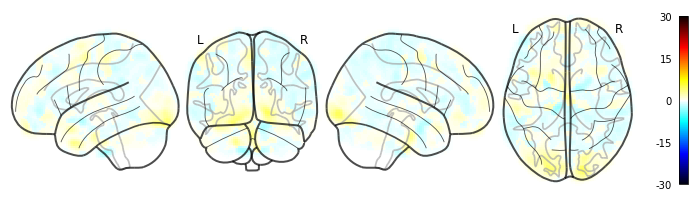

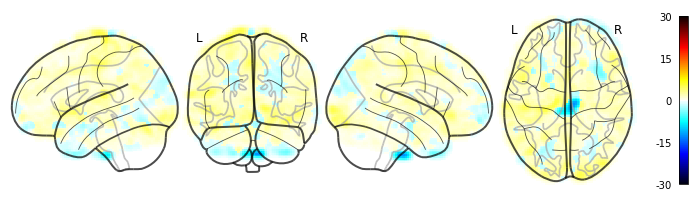

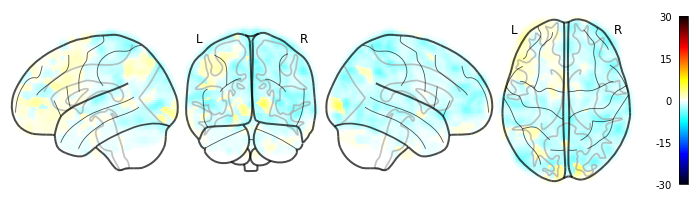

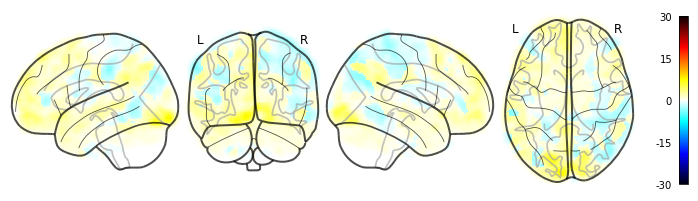

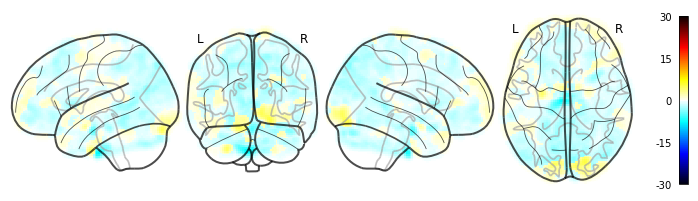

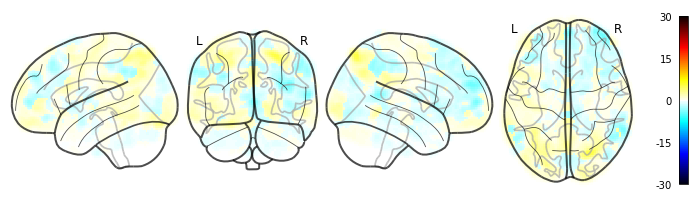

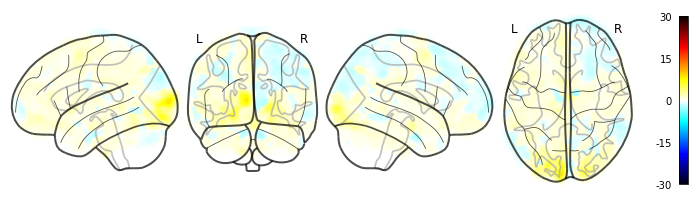

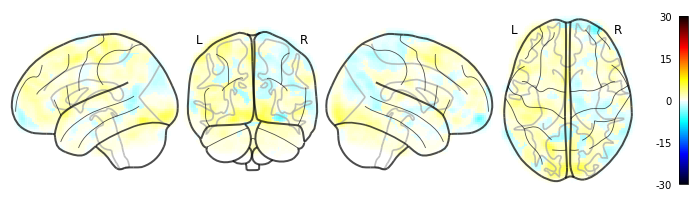

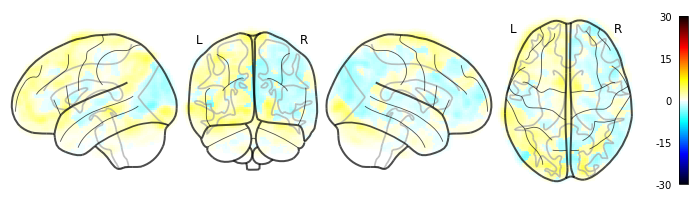

In [166]:
smooth_copes = []
for k,v in copes.items():
    smooth_cope = nilearn.image.smooth_img(v[3], 8)
    smooth_copes.append(smooth_cope)
    nilearn.plotting.plot_glass_brain(smooth_cope,
                                      display_mode='lyrz', 
                                      colorbar=True, 
                                      plot_abs=False, 
                                      vmax=30)

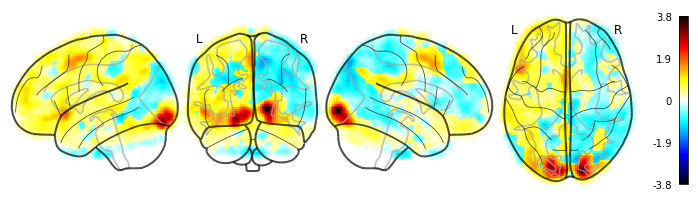

In [168]:
nilearn.plotting.plot_glass_brain(nilearn.image.mean_img(smooth_copes),
                                  display_mode='lyrz', 
                                  colorbar=True, 
                                  plot_abs=False)

# Plot the individual brain masks

/opt/conda/lib/python3.7/site-packages/nilearn/plotting/displays.py:591: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  facecolor=facecolor)


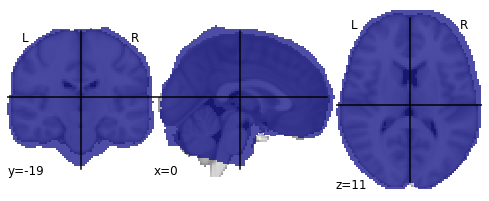

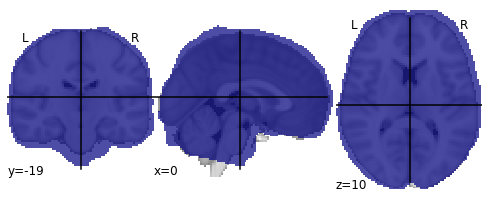

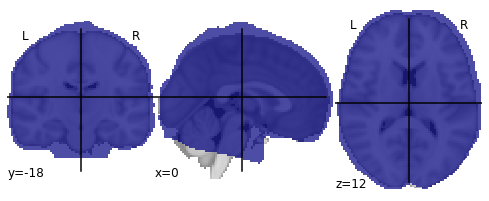

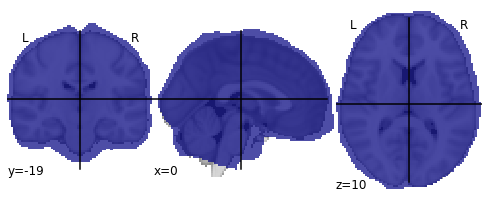

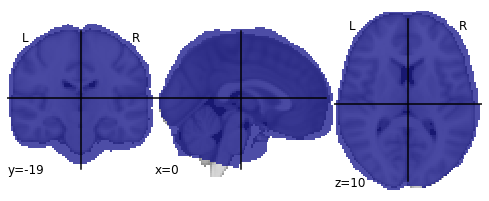

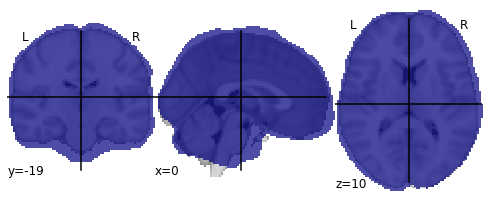

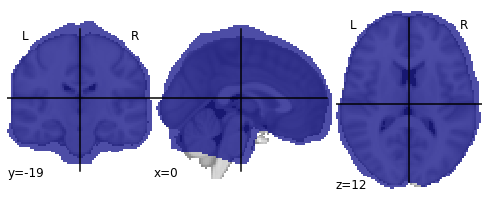

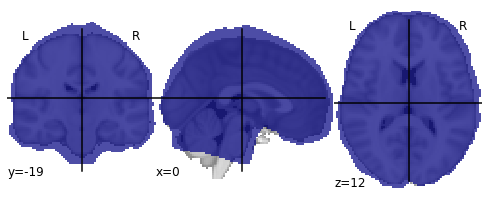

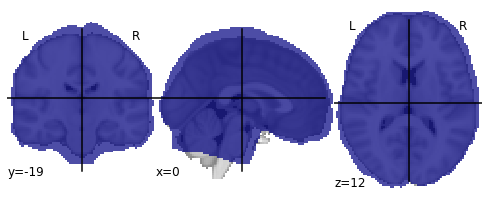

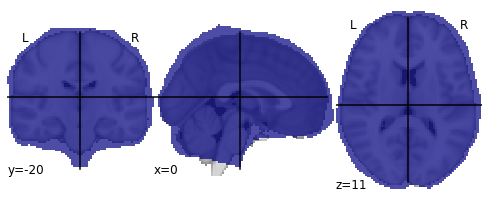

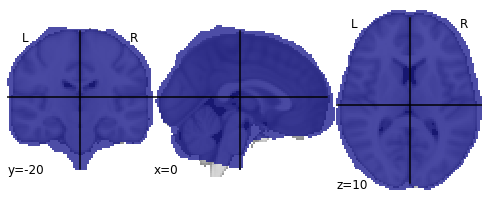

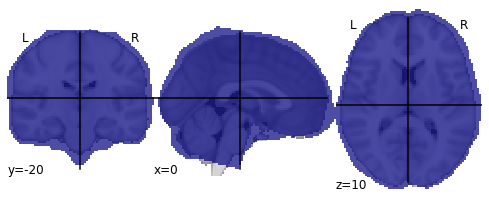

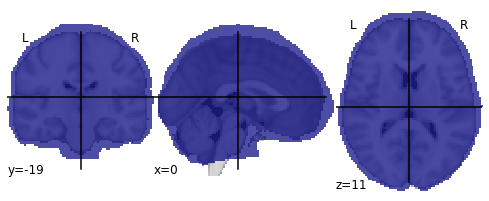

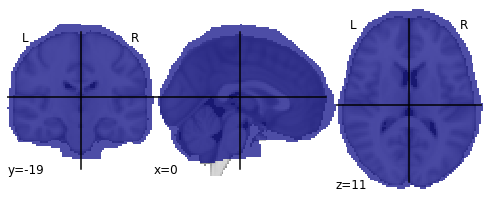

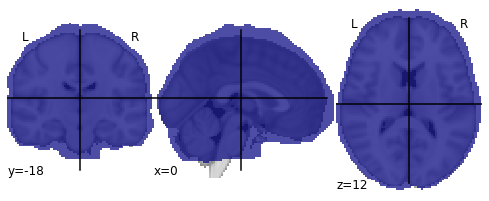

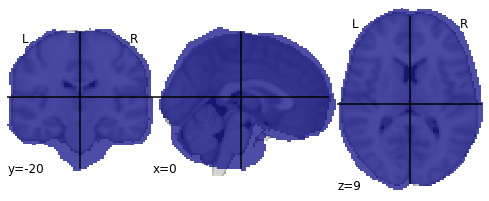

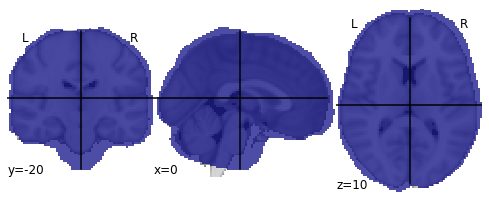

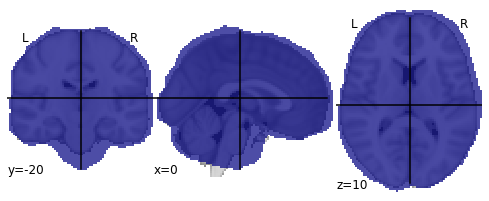

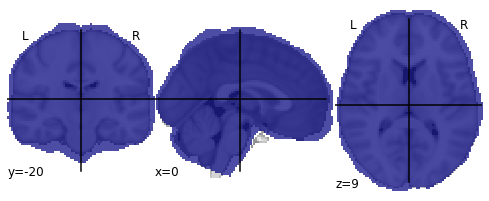

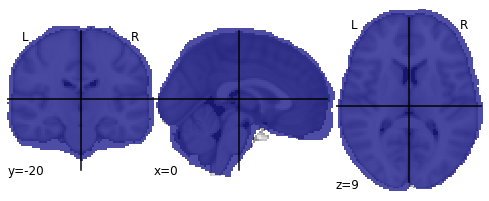

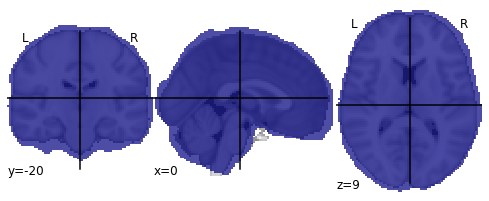

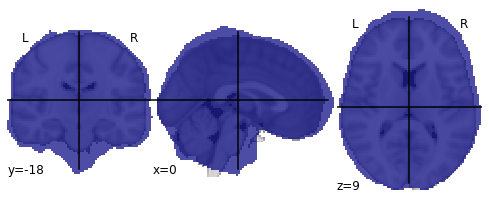

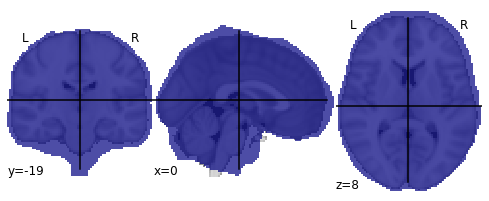

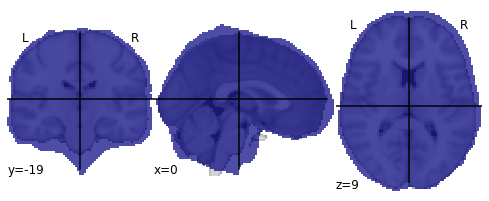

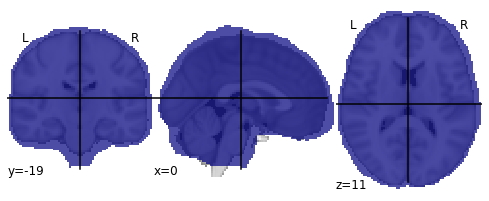

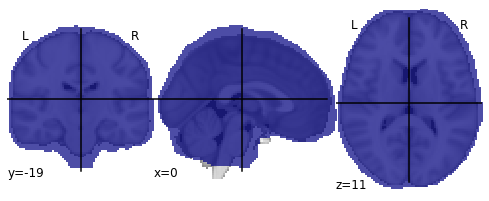

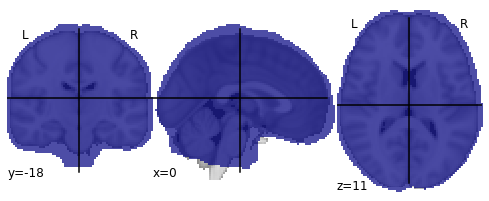

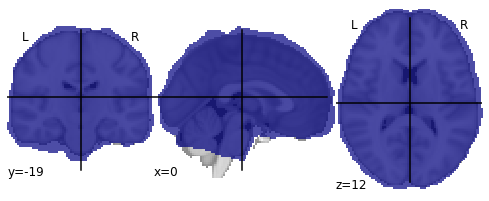

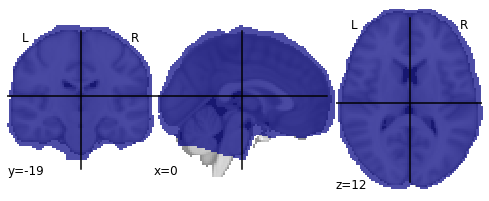

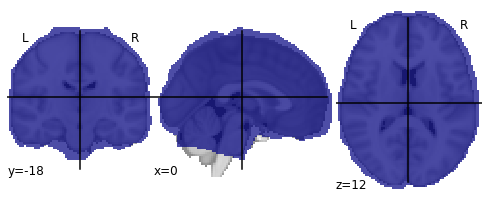

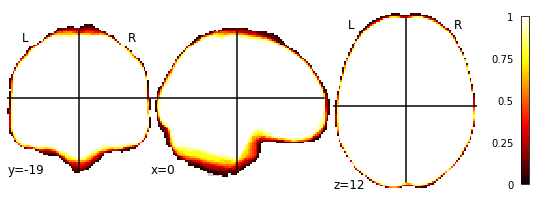

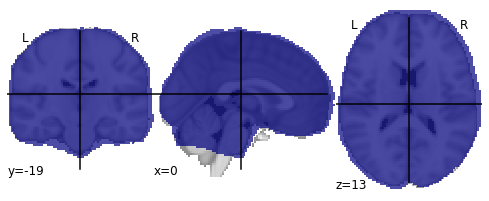

In [170]:

brainmasks = glob.glob(os.path.join(datadir, "sub-*", "func", "*task-mental*space-MNI152NLin2009cAsym*_brainmask.nii*"))

for mask in brainmasks:
    nilearn.plotting.plot_roi(mask)
    
mean_mask = nilearn.image.mean_img(brainmasks)
nilearn.plotting.plot_stat_map(mean_mask)
group_mask = nilearn.image.math_img("a>=0.95", a=mean_mask)
nilearn.plotting.plot_roi(group_mask)

In [171]:
!mkdir -p {datadir}/custom_modelling/

copes_concat = nilearn.image.concat_imgs(smooth_copes, auto_resample=True)
copes_concat.to_filename(os.path.join(datadir, "custom_modelling", "YOURCONTRASTNAMEHERE_copes.nii.gz"))

group_mask = nilearn.image.resample_to_img(group_mask, copes_concat, interpolation='nearest')
group_mask.to_filename(os.path.join(datadir, "custom_modelling", "group_mask.nii.gz"))

In [172]:
group_mask.shape


(97, 115, 97)

# Run permutation testing

In [173]:
randomise = mem.cache(fsl.Randomise)
randomise_results = randomise(in_file=os.path.join(datadir, "custom_modelling", "YOURCONTRASTNAMEHERE_copes.nii.gz"),
                              mask=os.path.join(datadir, "custom_modelling", "group_mask.nii.gz"),
                              one_sample_group_mean=True,
                              tfce=True,
                              vox_p_values=True,
                              num_perm=500)
randomise_results.outputs

191109-16:47:37,961 nipype.workflow INFO:
	 [Node] Setting-up "b206450c12979b1f649d0a2a1eabc00b" in "/home/jovyan/nipype_mem/nipype-interfaces-fsl-model-Randomise/b206450c12979b1f649d0a2a1eabc00b".
191109-16:47:37,965 nipype.workflow INFO:
	 [Node] Running "b206450c12979b1f649d0a2a1eabc00b" ("nipype.interfaces.fsl.model.Randomise"), a CommandLine Interface with command:
randomise -i /home/jovyan/ClassData/custom_modelling/YOURCONTRASTNAMEHERE_copes.nii.gz -o "randomise" -m /home/jovyan/ClassData/custom_modelling/group_mask.nii.gz -n 500 -1 -T -x
191109-16:47:38,10 nipype.interface INFO:
	 stdout 2019-11-09T16:47:38.009924:randomise options: -i /home/jovyan/ClassData/custom_modelling/YOURCONTRASTNAMEHERE_copes.nii.gz -o randomise -m /home/jovyan/ClassData/custom_modelling/group_mask.nii.gz -n 500 -1 -T -x 
191109-16:47:38,349 nipype.interface INFO:
	 stdout 2019-11-09T16:47:38.349658:Loading Data: 
191109-16:47:38,350 nipype.interface INFO:
	 stdout 2019-11-09T16:47:38.349658:Data loade


f_corrected_p_files = []
f_p_files = []
fstat_files = []
t_corrected_p_files = ['/home/jovyan/nipype_mem/nipype-interfaces-fsl-model-Randomise/b206450c12979b1f649d0a2a1eabc00b/randomise_tfce_corrp_tstat1.nii.gz']
t_p_files = []
tstat_files = ['/home/jovyan/nipype_mem/nipype-interfaces-fsl-model-Randomise/b206450c12979b1f649d0a2a1eabc00b/randomise_tstat1.nii.gz']

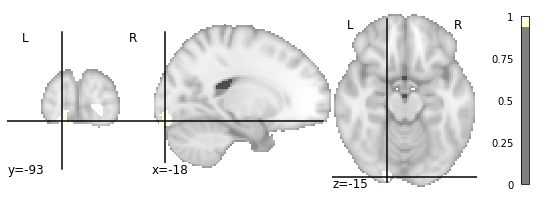

In [178]:
nilearn.plotting.plot_stat_map(randomise_results.outputs.t_corrected_p_files[0], threshold=0.95)


/opt/conda/lib/python3.7/site-packages/nilearn/plotting/displays.py:98: UserWarning: No contour levels were found within the data range.
  **kwargs)


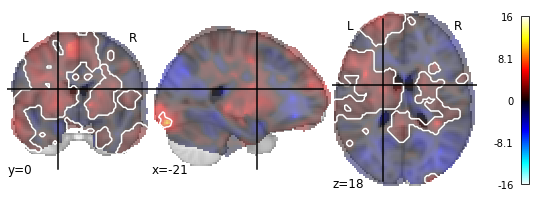

In [175]:
fig = nilearn.plotting.plot_stat_map(randomise_results.outputs.tstat_files[0], alpha=0.5, cut_coords=(-21, 0, 18))
fig.add_contours(randomise_results.outputs.t_corrected_p_files[0], levels=[0.95], colors='w')

# Other ways to plot your stat map
Check out the nilearn tutorials we ran earlier in the class

In [176]:
nilearn.plotting.plot_stat_map?

https://nilearn.github.io/plotting/index.html